### Importation des données

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import yaml
import importlib

import utils

In [9]:
importlib.reload(utils)

<module 'utils' from '/home/oclaich/SDD/Hackathon_Heart_Rate_Los_Tigros/utils.py'>

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

Feature: PHYSHLTH
['1 - 30', '77', '88', '99', 'BLANK']
Feature: MENTHLTH
['1 - 30', '77', '88', '99', 'BLANK']
Feature: POORHLTH
['1 - 30', '77', '88', '99', 'BLANK']
Feature: SLEPTIM1
['1 - 24', '77', '99', 'BLANK']
Feature: WEIGHT2
['50 - 0776', '7777', '9023 - 9352', '9999', 'BLANK']
Feature: HEIGHT3
['200 - 711', '7777', '9061 - 9998', '9999', 'BLANK']
Feature: MARIJAN1
['1 - 30', '77', '88', '99', 'BLANK']
Feature: ALCDAY4
['101 - 199', '201 - 299', '777', '888', '999', 'BLANK']
Feature: AVEDRNK3
['1 - 76', '77', '88', '99', 'BLANK']
Feature: DRNK3GE5
['1 - 76', '77', '88', '99', 'BLANK']
Feature: MAXDRNKS
['0', '1 - 76', '77', '99', 'BLANK']
Feature: COPDSMOK
['1 - 76', '77', '88', '99', 'BLANK']
Feature: _PACKDAY
['0 - 100', 'BLANK']


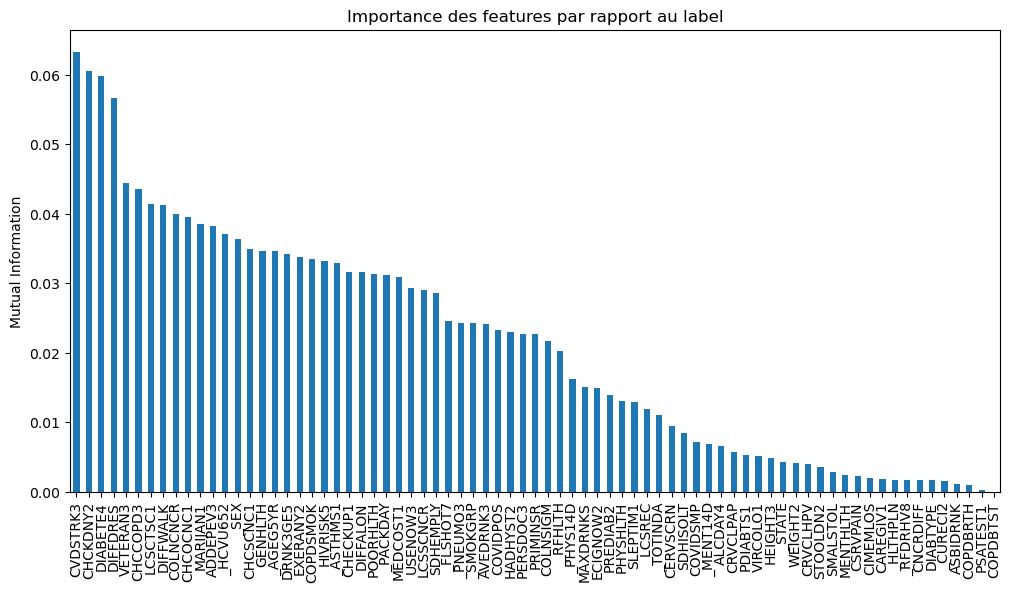

Nombre de features conservées : 63
Features conservées : ['CVDSTRK3', 'CHCKDNY2', 'DIABETE4', 'DIFFDRES', 'VETERAN3', 'CHCCOPD3', 'LCSCTSC1', 'DIFFWALK', 'COLNCNCR', 'CHCOCNC1', 'MARIJAN1', 'ADDEPEV3', '_HCVU652', '_SEX', 'CHCSCNC1', 'GENHLTH', '_AGEG5YR', 'DRNK3GE5', 'EXERANY2', 'COPDSMOK', 'HIVRISK5', '_ASTHMS1', 'CHECKUP1', 'DIFFALON', 'POORHLTH', '_PACKDAY', 'MEDCOST1', 'USENOW3', 'LCSSCNCR', 'SDHEMPLY', '_FLSHOT7', '_PNEUMO3', '_SMOKGRP', 'AVEDRNK3', 'COVIDPOS', 'HADHYST2', 'PERSDOC3', 'PRIMINSR', 'COLNSIGM', '_RFHLTH', '_PHYS14D', 'MAXDRNKS', 'ECIGNOW2', 'PREDIAB2', 'PHYSHLTH', 'SLEPTIM1', '_LCSREC', '_TOTINDA', 'CERVSCRN', 'SDHISOLT', 'COVIDSMP', '_MENT14D', 'ALCDAY4', 'CRVCLPAP', 'PDIABTS1', 'VIRCOLO1', 'HEIGHT3', '_STATE', 'WEIGHT2', 'CRVCLHPV', 'STOOLDN2', 'SMALSTOL', 'MENTHLTH']
    CVDSTRK3  CHCKDNY2  DIABETE4  DIFFDRES  VETERAN3  CHCCOPD3  LCSCTSC1  \
ID                                                                         
0          2         1         3         2     

In [10]:
X_train,y_train = utils.data_processing(df_train,True)
print(X_train.head())
print(y_train.head())

In [ ]:
X_test = utils.data_processing(df_test,False)
print(X_test.head())

In [3]:
# Génération du dictionnaire .json à partir du HTML
parser = HTMLParser()
html_snippet = "data/USCODE22_LLCP_102523.HTML"

codebook = parser.parse_html_codebook(html_snippet)

In [4]:
config = "features.yaml"

with open(config, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
data_reduced = data[config['features']].copy()

In [6]:
features_classification = {}

for feature in config['features']:
    features_classification[feature] = {}
    entry = next((item for item in codebook if item["sas_variable"] == feature), None)
    if entry:
        categories = list(set([cat['value'] for cat in entry['categories']]))
        categories.sort()
        if categories[0] != str(1):
            features_classification[feature] = 'numerical'

            print(f"Feature: {feature}")
            print(categories)

        else:
            features_classification[feature] = 'categorical'
    else:
        features_classification[feature] = 'unknown'

Feature: PHYSHLTH
['1 - 30', '77', '88', '99', 'BLANK']
Feature: MENTHLTH
['1 - 30', '77', '88', '99', 'BLANK']
Feature: POORHLTH
['1 - 30', '77', '88', '99', 'BLANK']
Feature: SLEPTIM1
['1 - 24', '77', '99', 'BLANK']
Feature: WEIGHT2
['50 - 0776', '7777', '9023 - 9352', '9999', 'BLANK']
Feature: HEIGHT3
['200 - 711', '7777', '9061 - 9998', '9999', 'BLANK']
Feature: MARIJAN1
['1 - 30', '77', '88', '99', 'BLANK']
Feature: ALCDAY4
['101 - 199', '201 - 299', '777', '888', '999', 'BLANK']
Feature: AVEDRNK3
['1 - 76', '77', '88', '99', 'BLANK']
Feature: DRNK3GE5
['1 - 76', '77', '88', '99', 'BLANK']
Feature: MAXDRNKS
['0', '1 - 76', '77', '99', 'BLANK']
Feature: COPDSMOK
['1 - 76', '77', '88', '99', 'BLANK']
Feature: _PACKDAY
['0 - 100', 'BLANK']
Feature: _CLLCPWT
['HIDDEN']


In [7]:
# Handle missing values for numerical features

continuous_columns = ['PHYSHLTH','MENTHLTH','POORHLTH',
                      'SLEPTIM1','WEIGHT2','HEIGHT3',
                      'MARIJAN1','ALCDAY4','AVEDRNK3','DRNK3GE5',
                      'MAXDRNKS','COPDSMOK','_PACKDAY',
                      ]

data_reduced["_PACKDAY"] = data_reduced["_PACKDAY"].fillna(data_reduced["_PACKDAY"].median())

data_reduced["COPDSMOK"] = data_reduced["COPDSMOK"].replace({88:0, 77:np.nan, 99:np.nan}).fillna(data_reduced["COPDSMOK"].median())

data_reduced["MAXDRNKS"] = data_reduced["MAXDRNKS"].replace({77:np.nan, 99:np.nan}).fillna(data_reduced["MAXDRNKS"].median())

data_reduced["DRNK3GE5"] = data_reduced["DRNK3GE5"].replace({88:0, 77:np.nan, 99:np.nan}).fillna(data_reduced["DRNK3GE5"].median())

data_reduced["AVEDRNK3"] = data_reduced["AVEDRNK3"].replace({88:0, 77:np.nan, 99:np.nan}).fillna(data_reduced["AVEDRNK3"].median())

data_reduced["MARIJAN1"] = data_reduced["MARIJAN1"].replace({88:0, 77:np.nan, 99:np.nan}).fillna(data_reduced["MARIJAN1"].median())

mask_alc_week = data_reduced["ALCDAY4"].astype(float).between(101, 199)
data_reduced.loc[mask_alc_week, "ALCDAY4"] = (data_reduced.loc[mask_alc_week, "ALCDAY4"] % 100) * 4
mask_alc_month = data_reduced["ALCDAY4"].between(201, 299)  
data_reduced.loc[mask_alc_month, "ALCDAY4"] = (data_reduced.loc[mask_alc_month, "ALCDAY4"] % 200)

data_reduced["ALCDAY4"] = data_reduced["ALCDAY4"].replace({888:0, 777:np.nan, 999:np.nan}).fillna(data_reduced["ALCDAY4"].median())

data_reduced["SLEPTIM1"] = data_reduced["SLEPTIM1"].replace({77:np.nan, 99:np.nan}).fillna(data_reduced["SLEPTIM1"].median())

data_reduced["POORHLTH"] = data_reduced["POORHLTH"].replace({88:0, 77:np.nan, 99:np.nan}).fillna(data_reduced["POORHLTH"].median())

data_reduced["MENTHLTH"] = data_reduced["MENTHLTH"].replace({88:0, 77:np.nan, 99:np.nan}).fillna(data_reduced["MENTHLTH"].median())

data_reduced["PHYSHLTH"] = data_reduced["PHYSHLTH"].replace({88:0, 77:np.nan, 99:np.nan}).fillna(data_reduced["PHYSHLTH"].median())

def ft_in_to_cm(s):
    s = str(int(float(s))).zfill(3)  
    feet = int(s[0])
    inches = int(s[1:])
    return feet * 30.48 + inches * 2.54

 
data_reduced["WEIGHT2"] = data_reduced["WEIGHT2"].astype(float)
mask_lb = data_reduced["WEIGHT2"].between(50, 776)
data_reduced.loc[mask_lb, "WEIGHT2"] = data_reduced.loc[mask_lb, "WEIGHT2"] * 0.45359237

mask_kg = data_reduced["WEIGHT2"].between(9023, 9352) 
data_reduced.loc[mask_kg, "WEIGHT2"] = data_reduced.loc[mask_kg, "WEIGHT2"] - 9000

mask_ft_in = data_reduced["HEIGHT3"].astype(float).between(200, 711)
data_reduced.loc[mask_ft_in, "HEIGHT3"] = data_reduced.loc[mask_ft_in, "HEIGHT3"].apply(ft_in_to_cm)

mask_kg = data_reduced["HEIGHT3"].between(9061, 9998)  
data_reduced.loc[mask_kg, "HEIGHT3"] = data_reduced.loc[mask_kg, "HEIGHT3"] - 9000

data_reduced["WEIGHT2"] = data_reduced["WEIGHT2"].replace({7777:np.nan, 9999:np.nan}).fillna(data_reduced["WEIGHT2"].median())

data_reduced["HEIGHT3"] = data_reduced["HEIGHT3"].replace({7777:np.nan, 9999:np.nan}).fillna(data_reduced["HEIGHT3"].median())


In [8]:
data_reduced[continuous_columns].head()

,PHYSHLTH,MENTHLTH,POORHLTH,SLEPTIM1,WEIGHT2,HEIGHT3,MARIJAN1,ALCDAY4,AVEDRNK3,DRNK3GE5,MAXDRNKS,COPDSMOK,_PACKDAY
0,30.0,0.0,0.0,7.0,74.842741,157.48,88.0,8.0,1.0,0.0,2.0,88.0,2.00
1,0.0,15.0,14.0,6.0,64.863709,157.48,88.0,30.0,2.0,88.0,2.0,88.0,0.50
2,0.0,0.0,88.0,8.0,129.273825,180.34,88.0,0.0,2.0,88.0,2.0,88.0,0.75
3,0.0,0.0,88.0,10.0,111.130131,182.88,88.0,0.0,2.0,88.0,2.0,88.0,0.50
4,0.0,3.0,0.0,7.0,81.646627,185.42,88.0,5.0,4.0,2.0,7.0,88.0,0.50


In [9]:
categorical_features = [feat for feat, info in features_classification.items() if info == 'categorical']

data_reduced[categorical_features] = data_reduced[categorical_features].fillna(-1)
data_reduced[categorical_features] = (
    data_reduced[categorical_features].astype('category').apply(lambda x: x.cat.codes)
)


In [10]:
data_reduced = data_reduced.set_index('ID')

In [15]:
data_reduced

,_STATE,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,PRIMINSR,PERSDOC3,MEDCOST1,CHECKUP1,EXERANY2,...,_AGEG5YR,_CURECI2,_PACKDAY,_SMOKGRP,_LCSREC,_RFDRHV8,_FLSHOT7,_PNEUMO3,TARGET,_CLLCPWT
ID,,,,,,,,,,,,,,,,,,,,,
0,1,3,1.518224,-0.419364,-1.008502,3,1,2,1,1,...,12,0,3.550165,3,0,0,1,1,True,NaN
1,6,3,-0.409570,0.623837,-0.671989,10,2,2,3,2,...,2,0,-0.233186,4,0,2,0,0,False,NaN
2,15,2,-0.409570,-0.419364,1.106724,1,1,2,1,1,...,4,0,0.397373,3,0,0,0,0,False,NaN
3,35,3,-0.409570,-0.419364,1.106724,1,3,2,1,1,...,7,0,-0.233186,4,0,0,0,0,False,NaN
4,21,3,-0.409570,-0.210724,-1.008502,9,2,2,1,1,...,0,0,-0.233186,4,0,0,0,0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224995,1,3,-0.409570,-0.419364,1.106724,3,2,2,1,1,...,10,0,1.027931,2,2,0,2,3,True,NaN
224996,13,3,0.554327,0.623837,-0.647952,2,3,1,4,2,...,8,0,0.397373,3,0,0,0,0,False,NaN
224997,34,3,-0.409570,-0.419364,1.106724,1,3,2,1,1,...,6,0,-0.233186,4,0,0,0,0,False,NaN


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_reduced[continuous_columns] = scaler.fit_transform(data_reduced[continuous_columns])

In [12]:
X = data_reduced.drop('TARGET', axis = 1)
y = data_reduced['TARGET'].astype(int)

In [14]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
mi_series.plot(kind='bar')
plt.ylabel('Mutual Information')
plt.title('Importance des features par rapport au label')
plt.show()


mi_cumsum = mi_series.cumsum()
mi_total = mi_series.sum()

threshold = 0.99 * mi_total
features_99 = mi_cumsum[mi_cumsum <= threshold].index.tolist()

print("Nombre de features conservées :", len(features_99))
print("Features conservées :", features_99)

ValueError: Input X contains NaN.

In [78]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

xgb =  XGBClassifier()

xgb.fit(X, y)

y_pred = xgb.predict(X)
print(f1_score(y_pred, y))

0.3033774442030417


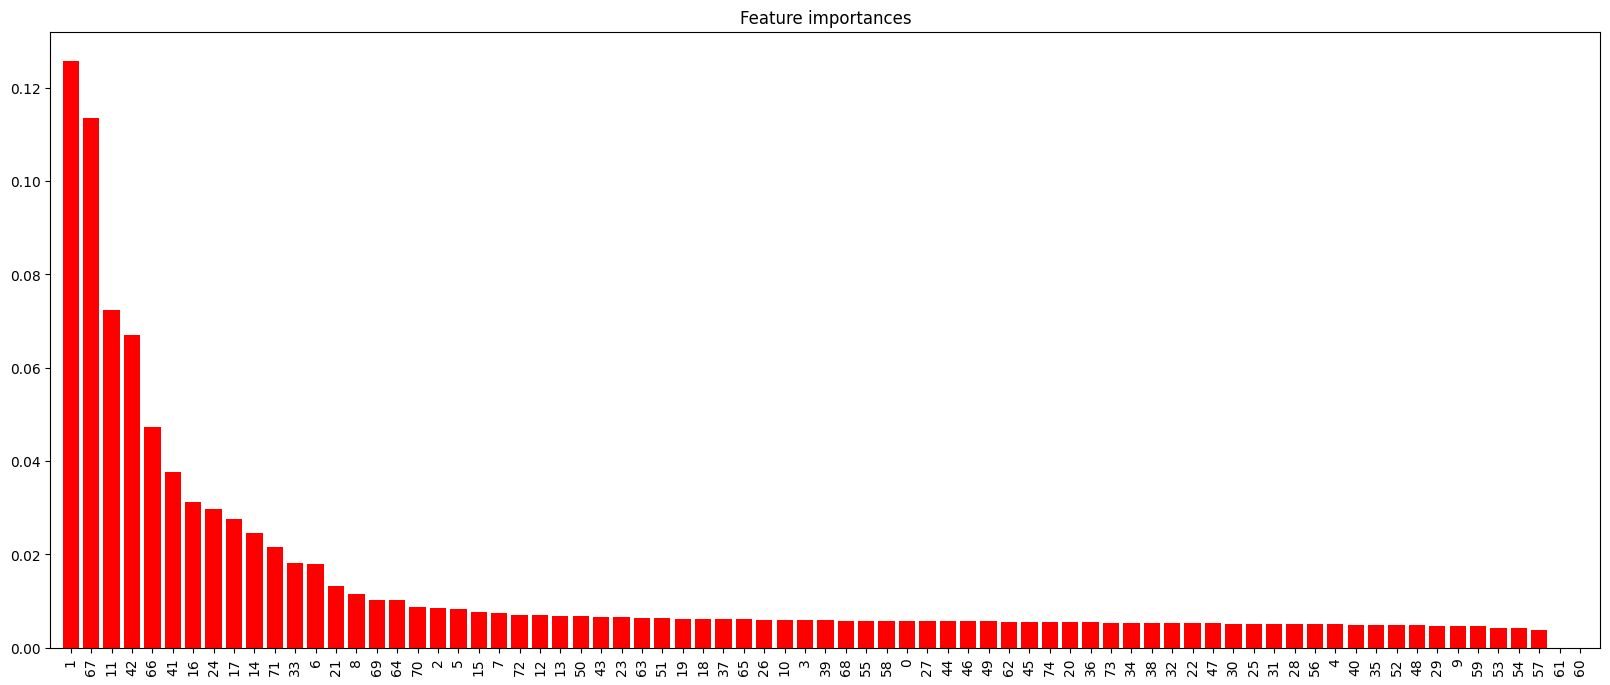

Nombre de features conservées : 70
Features conservées : [ 1 67 11 42 66 41 16 24 17 14 71 33  6 21  8 69 64 70  2  5 15  7 72 12
 13 50 43 23 63 51 19 18 37 65 26 10  3 39 68 55 58  0 27 44 46 49 62 45
 74 20 36 73 34 38 32 22 47 30 25 31 28 56  4 40 35 52 48 29  9 59]


In [79]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(20,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), indices, rotation = 90)
plt.xlim([-1, X.shape[1]])
plt.show()

mi_cumsum = importances[indices].cumsum()
mi_total = importances[indices].sum()

threshold = 0.99 * mi_total
features_99 = mi_cumsum[mi_cumsum <= threshold]
indice = indices[mi_cumsum <= threshold]
print("Nombre de features conservées :", len(features_99))
print("Features conservées :", indice)